# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [216]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
import time
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder
import random

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [217]:
# load in the data - I saved locally with "," as a separator
# please change to ";" for the original dataset

try:
    azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')
    customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')
except:
    print("You do not have access to the files.")

In [275]:
# read feature information
try:
    feat_top = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    feat_det = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    feat_sum = pd.read_csv('DIAS_Attributes_Summary_DSND1.csv')
except:
    print("You do not have access to the files.")

### Part 0.0: Understanding feature information

The provided Excel Data seem to contain important information about the values of each feature - notably, values that correspond to "unknown" data.

In [219]:
f_rows, f_cols = feat_det.shape
print("Detailed mapping of data values for each feature")
print("Number of rows: {}".format(f_rows))
print("Number of cols: {}".format(f_cols))
print(feat_det.head())

Detailed mapping of data values for each feature
Number of rows: 2258
Number of cols: 5
   Unnamed: 0 Attribute         Description Value                     Meaning
0         NaN  AGER_TYP  best-ager typology    -1                     unknown
1         NaN       NaN                 NaN     0  no classification possible
2         NaN       NaN                 NaN     1             passive elderly
3         NaN       NaN                 NaN     2            cultural elderly
4         NaN       NaN                 NaN     3   experience-driven elderly


In [220]:
# Using forward fill to eliminate NaNs from Attribute Column
feat_det['Attribute'].ffill(inplace = True)

In [221]:
# Correcting for "GROB" Categories - formatation error leads to "NaN" Values

print(feat_det[feat_det['Meaning'].isna() == True])
feat_det['Meaning'].ffill(inplace = True)

      Unnamed: 0        Attribute Description Value Meaning
1906         NaN  LP_FAMILIE_GROB         NaN     4     NaN
1907         NaN  LP_FAMILIE_GROB         NaN     5     NaN
1909         NaN  LP_FAMILIE_GROB         NaN     7     NaN
1910         NaN  LP_FAMILIE_GROB         NaN     8     NaN
1912         NaN  LP_FAMILIE_GROB         NaN    10     NaN
1913         NaN  LP_FAMILIE_GROB         NaN    11     NaN
1977         NaN   LP_STATUS_GROB         NaN     2     NaN
1979         NaN   LP_STATUS_GROB         NaN     4     NaN
1980         NaN   LP_STATUS_GROB         NaN     5     NaN
1982         NaN   LP_STATUS_GROB         NaN     7     NaN
1984         NaN   LP_STATUS_GROB         NaN     9     NaN


In [222]:
# Creating a new data frame with "unknown" values - which are equivalent to NaN, but receive a number
miss_val = feat_det[(feat_det['Meaning'] == 'unknown')][['Attribute', 'Value']].reset_index(drop=True)

# Checking if there are any duplicated Attributes, that would need to be consolidated
# True if no extra steps are required
print(eval('miss_val[\'Attribute\'].nunique()==miss_val.shape[0]'))

True


In [223]:
# Transforming 'Value' Strings into lists of integers

def split_transform(x):
    try:
        a_list = x.split(',')
        map_object = map(int, a_list)
        list_ints = list(map_object)
        return list_ints
    except:
        return [x]

miss_val['Value'] = miss_val['Value'].apply(split_transform)

### Part 0.1: General Population Dataset

The goal of this section is to understand the "Azdias" dataset, and provide information for the data cleaning.

In [224]:
# exploring the general population dataset

a_rows, a_cols = azdias.shape
print("General Population at Large")
print("Number of rows: {}".format(a_rows))
print("Number of cols: {}".format(a_cols))
print(azdias.head())

General Population at Large
Number of rows: 891221
Number of cols: 366
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTAN

#### Replacing "Unknown" Values

In [225]:
# creating a copy of dataset to perform cleaning 
azdias_clean = azdias.copy()

In [226]:
# Replacing "unknown" values with NaN 
for index in miss_val.index:
    current_atr = miss_val.loc[index]['Attribute']
    current_list = miss_val.loc[index]['Value']
    for value in current_list:
        try: # some features are not present in azdias
            azdias_clean.loc[:, current_atr].replace(value, np.nan, inplace = True)
        except:
            continue

In [227]:
# Checking for random columns
# It seems to work!

for column in random.sample(set(miss_val['Attribute'].unique()),5):
    print('Column name:', column)
    print('Missing Values:', miss_val[miss_val['Attribute'] == column]['Value'].values)
    print('azdias_original： \n', azdias[column].value_counts(dropna=False), '\n')
    print('azdias_cleaned： \n', azdias_clean[column].value_counts(dropna=False), '\n \n')

Column name: KBA13_KW_120
Missing Values: [list([-1])]
azdias_original： 
 3.0    281415
1.0    226709
NaN    105800
4.0     94774
0.0     85028
5.0     73739
2.0     23756
Name: KBA13_KW_120, dtype: int64 

azdias_cleaned： 
 3.0    281415
1.0    226709
NaN    105800
4.0     94774
0.0     85028
5.0     73739
2.0     23756
Name: KBA13_KW_120, dtype: int64 
 

Column name: KBA13_HERST_AUDI_VW
Missing Values: [list([-1])]
azdias_original： 
 3.0    336178
2.0    172160
4.0    149322
NaN    105800
1.0     72901
5.0     54860
Name: KBA13_HERST_AUDI_VW, dtype: int64 

azdias_cleaned： 
 3.0    336178
2.0    172160
4.0    149322
NaN    105800
1.0     72901
5.0     54860
Name: KBA13_HERST_AUDI_VW, dtype: int64 
 

Column name: KBA13_FAB_SONSTIGE
Missing Values: [list([-1])]
azdias_original： 
 3.0    345124
2.0    167481
4.0    153466
NaN    105800
5.0     61004
1.0     58346
Name: KBA13_FAB_SONSTIGE, dtype: int64 

azdias_cleaned： 
 3.0    345124
2.0    167481
4.0    153466
NaN    105800
5.0     

#### Dealing with Missing Values - Columns

In [228]:
# Identifying the proportion of NaN values

nan_prop = azdias_clean.isna().mean().round(4) * 100

In [229]:
# Sorting and counting values 

nan_prop.value_counts().sort_index()

0.00      87
0.54      19
2.06       1
5.75       1
8.25      10
8.30       1
8.52       3
10.45     13
10.52      3
10.88      1
10.91      5
10.93      1
10.97      2
11.11      3
11.87    116
12.07      1
12.14      1
12.15      1
12.35      1
12.48      3
13.07      7
13.60      1
14.96      6
16.44      1
16.52      1
16.61      1
16.62     55
17.74      2
28.85      9
29.50      1
53.47      1
65.60      1
73.40      1
76.02      1
90.90      1
96.69      1
99.31      1
99.76      1
99.86      1
dtype: int64

In [230]:
# Analyzing the results
clean_cols = len(nan_prop[nan_prop == 0]) 
nan_cols = nan_prop.shape[0] - clean_cols

print('{} ({:0.1f}%) columns have no missing values'.format(clean_cols, 100*clean_cols/nan_prop.shape[0]))
print('{} ({:0.1f}%) columns have at least one missing value'.format(nan_cols, 100*nan_cols/nan_prop.shape[0]))

87 (23.8%) columns have no missing values
279 (76.2%) columns have at least one missing value


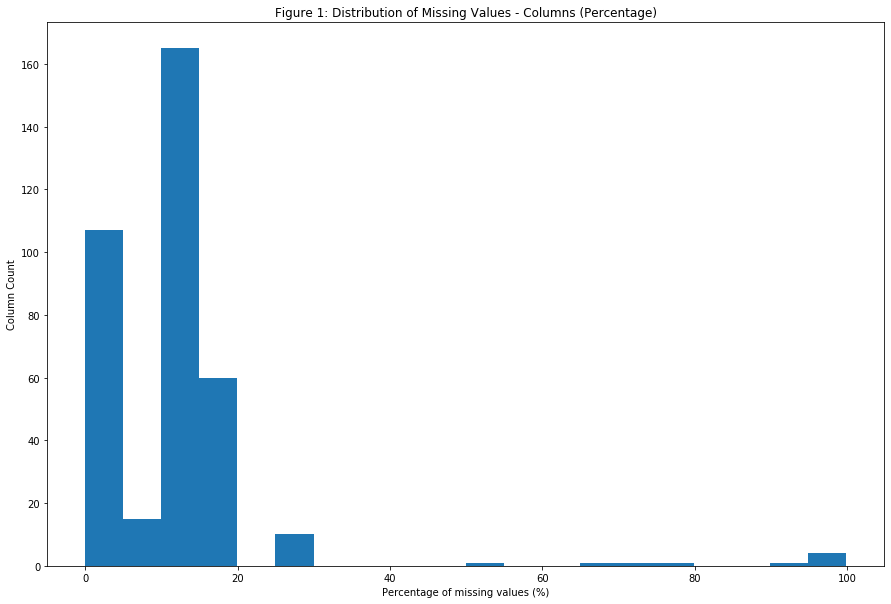

In [231]:
# Distribution of missing values

plt.figure(figsize=(15,10));
plt.hist(nan_prop.values, bins=20);
plt.title('Figure 1: Distribution of Missing Values - Columns (Percentage)')
plt.xlabel('Percentage of missing values (%)');
plt.ylabel('Column Count');

In [232]:
# Analyzing the results (>=20% missing values are clearly outliers)
clean_cols = len(nan_prop[nan_prop < 20]) 
nan_cols = nan_prop.shape[0] - clean_cols

print('{} ({:0.1f}%) columns have less than 20% missing values'.format(clean_cols, 100*clean_cols/nan_prop.shape[0]))
print('{} ({:0.1f}%) columns have at least 20% of its values missing'.format(nan_cols, 100*nan_cols/nan_prop.shape[0]))

347 (94.8%) columns have less than 20% missing values
19 (5.2%) columns have at least 20% of its values missing


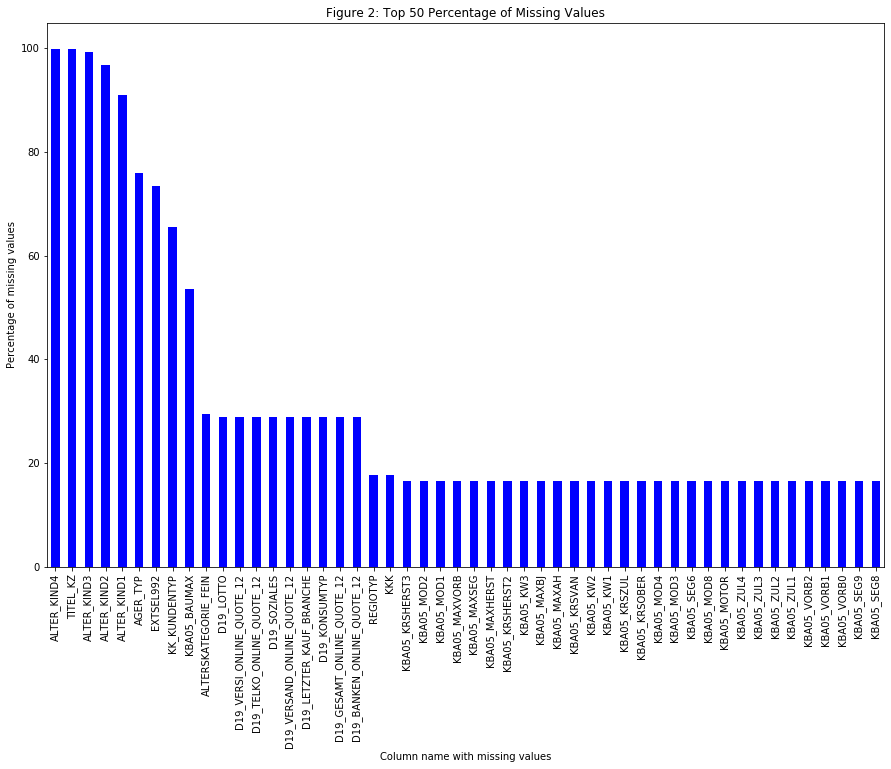

In [233]:
# Visualizing the percentage of NaNs

w_nan_prop = (nan_prop[nan_prop > 0].sort_values(ascending=False))[:50]

w_nan_prop.plot.bar(figsize=(15,10), facecolor ='b')
plt.title('Figure 2: Top 50 Percentage of Missing Values')
plt.xlabel('Column name with missing values')
plt.ylabel('Percentage of missing values')
plt.show()

From the chart above, we notice some columns with more than 1/5 of its values missing. Figure 1 shows that those are clearly the outliers - 94.8% of the columns (347) have less than 20% of its values missing. To reduce the dataset's complexity, I will choose to drop those 19 columns in the data cleaning step.

In [234]:
azdias_col_drop = list(nan_prop[nan_prop >= 20].index)
azdias_col_keep = list(nan_prop[nan_prop < 20].index)

azdias_clean = azdias_clean[azdias_col_keep]

#### Dealing with Missing Values - Rows

In [235]:
# Missing Values in rows

na_rows_sum = azdias_clean.isna().sum(axis=1)

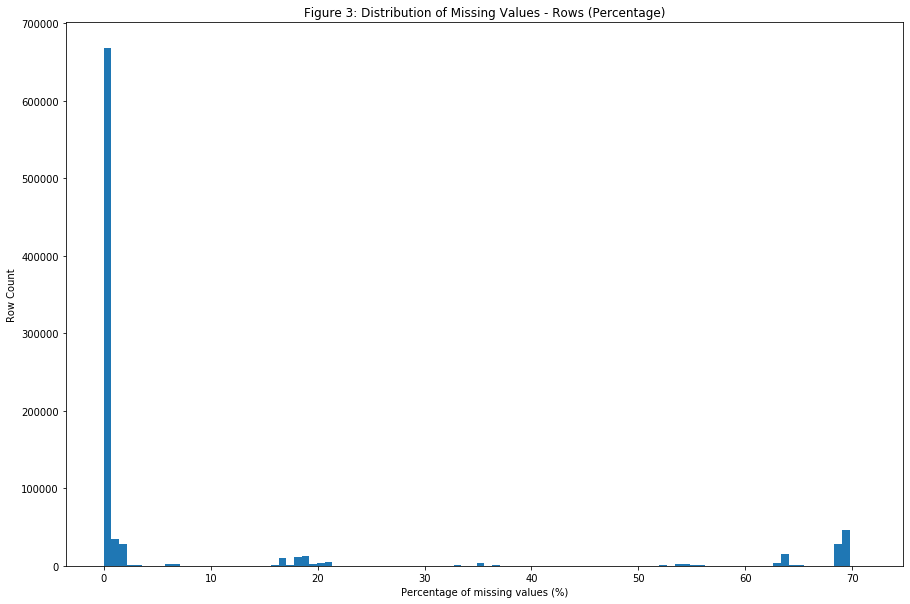

In [236]:
# Distribution of missing values in percentual values

prop_nan_rows = 100*na_rows_sum.values/len(azdias_clean.columns)
plt.figure(figsize=(15,10));
plt.hist(prop_nan_rows, bins=100);
plt.title('Figure 3: Distribution of Missing Values - Rows (Percentage)')
plt.xlabel('Percentage of missing values (%)');
plt.ylabel('Row Count');

In [237]:
# Analyzing the results (>=10% missing values are clearly outliers)
clean_rows = len(prop_nan_rows[prop_nan_rows < 10]) 
nan_rows = prop_nan_rows.shape[0] - clean_rows

print('{} ({:0.1f}%) rows have less than 10% missing values'.format(clean_rows, 100*clean_rows/prop_nan_rows.shape[0]))
print('{} ({:0.1f}%) rows have at least 10% of its values missing'.format(nan_rows, 100*nan_rows/prop_nan_rows.shape[0]))

737287 (82.7%) rows have less than 10% missing values
153934 (17.3%) rows have at least 10% of its values missing


As Figure 3 and the analysis above show, removing rows with at least 10% of its values missing will still retain 82.7% of the values. To increase the informative value and meaningfullness of the dataset, I will choose to remove those rows in the data cleaning step.

In [238]:
azdias_row_drop = list(na_rows_sum[prop_nan_rows >= 10].index)
azdias_row_keep = list(na_rows_sum[prop_nan_rows < 10].index)

azdias_clean = azdias_clean.drop(azdias_row_drop)

#### Analyzing and selecting features

This section uses the information provided in the Data Science Nanodegree Term 1, in order to identify the true data types of the data set (using the file *DIAS_Attributes_Summary.csv*). However, please note that the provided information is not complete.

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I will need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. There are five types to be found:

1. Numeric
2. Interval
3. Ordinal
4. Mixed
5. Categorical

I will keep the numeric and interval data without changes.
Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, I made the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
Special handling will be necessary for the remaining two variable types: categorical, and 'mixed'.

In [239]:
# Analyzing data types and their frequency - majority is stored as a number

azdias_clean.dtypes.value_counts()

float64    255
int64       87
object       5
dtype: int64

In [240]:
# the feature summary file from DSND1 comes in handy to identify data types
# Interestingly enough, the majority of categorical data is store as a number

feat_sum['type'].value_counts()

ordinal        258
categorical     50
numeric          8
mixed            7
interval         1
Name: type, dtype: int64

In [241]:
# Checking if all azdias columns are present in feat_sum

not_feat_sum = [col for col in azdias_clean.columns if col not in feat_sum['attribute'].values]
not_azdias = [col for col in feat_sum['attribute'].values if col not in azdias_clean.columns]

print('{} AZDIAS Attributes have no information on data type.'.format(len(not_feat_sum)))
print('{} Feature Summary Attributes were not found on AZDIAS.'.format(len(not_azdias)))

43 AZDIAS Attributes have no information on data type.
20 Feature Summary Attributes were not found on AZDIAS.


#### Deep Dive: Categorical Data

In [280]:
feat_sum

,Unnamed: 0,attribute,information_level,type,missing_or_unknown
0,"0,AGER_TYP,person,categorical,""[-1,0]""",NaN,NaN,NaN,NaN
1,"1,ALTERSKATEGORIE_GROB,person,ordinal,""[-1,0,9]""",NaN,NaN,NaN,NaN
2,"2,ANREDE_KZ,person,categorical,""[-1,0]""",NaN,NaN,NaN,NaN
3,3,CJT_GESAMTTYP,person,categorical,[0]
4,4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...,...
319,319,PLZ8_HHZ,plz8,ordinal,[-1]
320,320,PLZ8_GBZ,plz8,ordinal,[-1]
321,"321,ARBEIT,community,ordinal,""[-1,9]""",NaN,NaN,NaN,NaN
322,"322,ORTSGR_KLS9,community,ordinal,""[-1,0]""",NaN,NaN,NaN,NaN


In [279]:
feat_sum[feat_sum['type'] == 'categorical']['attribute']

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
48        KK_KUNDENTYP
49       D19_KONSUMTYP
88         OST_WEST_KZ
91      CAMEO_DEU_2015
Name: attribute, dtype: object

In [276]:
# First, let's take a look into categorical data

# Finding 'categorical' Attributes and how they were stored
cat_data = [col for col in feat_sum[feat_sum['type'] == 'categorical']['attribute'].values if col in azdias_clean.columns]

print('{} Attributes are listed as "categorical".'.format(len(cat_data)))
print('However, they are stored in the database as follows:')
print(azdias_clean[cat_data].dtypes.value_counts())

12 Attributes are listed as "categorical".
However, they are stored in the database as follows:
float64    9
int64      3
dtype: int64


In [277]:
# Now, let's look into their values and find out where re-encoding is necessary

att_to_re_encode = []

for attribute in cat_data:
    possible_values = azdias_clean[attribute].unique()
    for value in possible_values:
        try:
            float(value)
        except:
            # attribute value is not numerical - re-encoding is needed!
            att_to_re_encode.append(attribute)
            break

# Visualizing those attributes and their values
for attribute in att_to_re_encode:
    print(attribute)
    print(azdias_clean[attribute].value_counts(), '\n')

In [247]:
# OST_WEST_KZ requires re-encoding.
# I will choose 1 for "West", 0 for "Ost"

azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)

In [271]:
# CAMEO_DEUG_2015 requires re-encoding.
# All numbers will be converted to float and then string; X will be replaced by nan

azdias_clean['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)

azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].apply(float).apply(str)

# check
azdias_clean['CAMEO_DEUG_2015'].value_counts()

8.0    128860
6.0    100692
9.0     99451
4.0     95582
2.0     76611
3.0     76321
7.0     72483
5.0     49713
1.0     34234
nan      3340
Name: CAMEO_DEUG_2015, dtype: int64

In [272]:
# CAMEO_DEU_2015 has several categories. This might be harmful when creating dummy columns
# So I will choose to drop it 

print('There are {} distinct categories of the CAMEO_DEU_2015 Attribute.'.format(len(azdias_clean['CAMEO_DEU_2015'].unique())))

azdias_clean.drop(columns=['CAMEO_DEU_2015'], inplace=True)

KeyError: 'CAMEO_DEU_2015'

In [251]:
# Now, let's examine the other columns saved as "object"

print(azdias_clean.select_dtypes('object'))

# "EIGENFUEGT_AM" is a data stamp of (probably) the entry on the database
# That's irrelevant to our problem, so we can drop the column

azdias_clean.drop(columns=['EINGEFUEGT_AM'], inplace=True)

       CAMEO_DEUG_2015 CAMEO_INTL_2015        EINGEFUEGT_AM
1                  8.0              51  1992-02-10 00:00:00
2                  4.0              24  1992-02-12 00:00:00
3                  2.0              12  1997-04-21 00:00:00
4                  6.0              43  1992-02-12 00:00:00
5                  8.0              54  1992-02-12 00:00:00
...                ...             ...                  ...
891216             7.0              41  1992-02-10 00:00:00
891217             9.0              51  1992-02-10 00:00:00
891218             4.0              24  1992-02-10 00:00:00
891219             9.0              51  1992-02-12 00:00:00
891220             6.0              43  1992-02-10 00:00:00

[737287 rows x 3 columns]


In [278]:
# Finally, let's look at our categorical columns and re-encode those with multiple values:

fin_cat_data = [col for col in feat_sum[feat_sum['type'] == 'categorical']['attribute'].values if col in azdias_clean.columns]
to_encode = azdias_clean[fin_cat_data].nunique()[azdias_clean[fin_cat_data].nunique()>2]
to_encode

CJT_GESAMTTYP       6
FINANZTYP           6
GFK_URLAUBERTYP    12
LP_FAMILIE_FEIN    12
LP_FAMILIE_GROB     6
LP_STATUS_FEIN     10
LP_STATUS_GROB      5
SHOPPER_TYP         4
dtype: int64

In [267]:
azdias_clean['D19_GESAMT_ONLINE_DATUM']

1         10
2         10
3         10
4          1
5          3
          ..
891216     2
891217    10
891218     7
891219    10
891220    10
Name: D19_GESAMT_ONLINE_DATUM, Length: 737287, dtype: int64

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

### Part 0.2. Writing a cleaning function

This function contains all pre-processing steps, and yields clean data sets, ready for analysis:
* Replace "Unknown" Values with NaN
* Removes Columns with at least 20% NaN
* Removes Rows with at least 10% NaN
* Removes CAMEO_DEU_2019
* Replaces Categorical Data with Dummy Variables

In [4]:
# exploring the customers' dataset

c_rows, c_cols = customers.shape
print("Arvato Customers")
print("Number of rows: {}".format(c_rows))
print("Number of cols: {}".format(c_cols))
print(customers.head())

Arvato Customers
Number of rows: 191652
Number of cols: 369
      LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOH

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')